# Text Summarization - Encoder Decoder with Attention Mechanism

### Importing Basic libraries

In [5]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing Data

In [6]:
#Kaggle
data_path = '../input/news-summary/news_summary_more.csv'
data = pd.read_csv(data_path)
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [7]:
data.drop_duplicates(subset=['headlines'],inplace=True)
data.reset_index(inplace=True, drop=True)

In [8]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


In [9]:
data['headlines'] = data['headlines'].apply(preprocess)
data['text'] = data['text'].apply(preprocess)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ upgrad learner switches career ml al 90 salary hike _END_
Text:
saurav kant alumnus upgrad iiit b pg program machine learning artificial intelligence sr systems engineer infosys almost 5 years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered 3 lakh careers

Summary:
_START_ delhi techie wins free food swiggy one year cred _END_
Text:
kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cultfit more



In [10]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

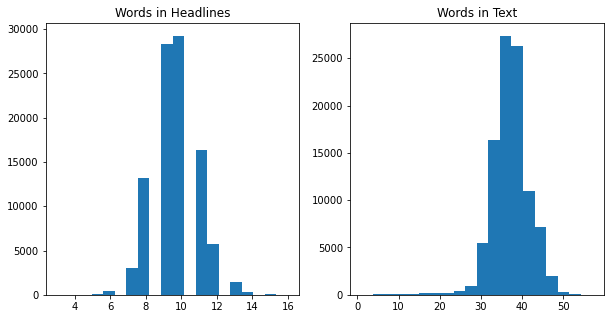

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

### Embedding Matrix from Glove


In [12]:
glove_size = 300
f = open('../input/glove42b300dtxt/glove.42B.300d.txt')

In [13]:
embeddings_index = dict()
for line in f:
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

In [14]:
words_source_train = []
for i in data['text'] :
  words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
  if i in words_glove:
    words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 3665888
the unique words in the corpus 90013
The number of words that are present in both glove vectors and our corpus are 70834 which is nearly 79.0% 
word 2 vec length 70834


In [15]:
print(list(words_source_train - inter_words)[:20])

['', 'nlaunched', 'oxygencapable', 'realdonaldtrump', 'statementsof', 'laao', 'americathey', 'nandlala', 'okalipuram', 'gastroenteritisi', 'ontobe', 'againstgovernment', 'krasava', 'zahooruddin', 'playoutside', 'bahega', 'downsideis', 'matulya', 'prayagraj', 'punishmentI']


In [16]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['text'].apply(num)

In [17]:
data['unique_words'].value_counts()

0    72609
1    16367
2     6180
3     2200
4      651
5      192
6       62
7       14
8        5
Name: unique_words, dtype: int64

In [18]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [19]:
data

,headlines,text,unique_words
0,_START_ upgrad learner switches career ml al 9...,saurav kant alumnus upgrad iiit b pg program m...,0
1,_START_ delhi techie wins free food swiggy one...,kunal shah credit card bill payment platform c...,2
2,_START_ new zealand end rohit sharma led india...,new zealand defeated india 8 wickets fourth od...,0
3,_START_ aegon life iterm insurance plan helps ...,aegon life iterm insurance plan customers enjo...,0
4,_START_ known hirani yrs metoo claims true son...,speaking sexual harassment allegations rajkuma...,1
...,...,...,...
97351,_START_ crpf jawan axed death maoists chhattis...,crpf jawan tuesday axed death sharp edged weap...,0
97352,_START_ first song sonakshi sinha noor titled ...,uff yeh first song sonakshi sinha starrer upc...,2
97353,_START_ the matrix film get reboot reports _END_,according reports new version 1999 science fic...,0
97354,_START_ snoop dogg aims gun clown dressed trum...,new music video shows rapper snoop dogg aiming...,0


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [21]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

In [22]:
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [23]:
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [24]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, glove_size))
for word, i in x_t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 1917494 word vectors.


### Building Model

In [25]:
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
          
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  
            
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            
            fake_state = K.zeros_like(inputs)  
            fake_state = K.sum(fake_state, axis=[1, 2])  
            fake_state = K.expand_dims(fake_state)  
            fake_state = K.tile(fake_state, [1, hidden_size])  
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )
        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [26]:
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 300)      26975700    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 57, 500), (N 1602000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [27]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
history=model.fit([padded_xtrain,padded_ytrain[:,:-1]], padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:] ,epochs=10,batch_size=512, validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), callbacks=[es, model_checkpoint_callback])

Epoch 1/10
153/153 [==============================] - 123s 726ms/step - loss: 5.4903 - val_loss: 4.4870
Epoch 2/10
153/153 [==============================] - 111s 724ms/step - loss: 4.3859 - val_loss: 4.1232
Epoch 3/10
153/153 [==============================] - 111s 726ms/step - loss: 3.9125 - val_loss: 3.7661
Epoch 4/10
153/153 [==============================] - 111s 728ms/step - loss: 3.4617 - val_loss: 3.5413
Epoch 5/10
153/153 [==============================] - 110s 721ms/step - loss: 3.0830 - val_loss: 3.3986
Epoch 6/10
153/153 [==============================] - 111s 725ms/step - loss: 2.7450 - val_loss: 3.3098
Epoch 7/10
153/153 [==============================] - 111s 723ms/step - loss: 2.4478 - val_loss: 3.2606
Epoch 8/10
153/153 [==============================] - 111s 726ms/step - loss: 2.2101 - val_loss: 3.2327
Epoch 9/10
153/153 [==============================] - 111s 724ms/step - loss: 2.0015 - val_loss: 3.2130
Epoch 10/10
153/153 [==============================] - 111s 724m

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights("./model.27-3.27.h5")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

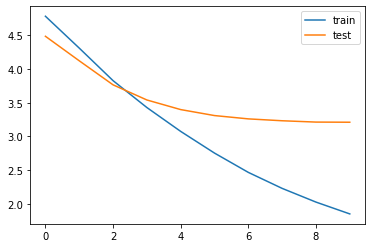

In [28]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

### Inference

In [29]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [30]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [32]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [46]:
for i in range(10):
  print("Review:",seq2text(padded_xtest[i]))
  print("Original summary:",seq2summary(padded_ytest[i]))
  print("Predicted summary:",decode_sequence(padded_xtest[i]))
  print("\n")

Review: streaker peace love written across chest crashed olympic skating rink wearing pink tutu winter games pyeongchang incident occurred right men 1 000 metre speed skating event friday streaker used monkey pouch cover genitals later fell face forward ice 
Original summary: man crashes olympic skating rink wearing tutu 
Predicted summary:  runner makes olympic skating rink cage qualifies


Review: delhi high court upheld trial court order granting anticipatory bail congress leader sajjan kumar alleged murder three sikhs 1984 riots pm indira gandhi assassination court noted special investigation team challenging trial court order make ground bail cancellation 
Original summary: hc upholds bail order cong leader accused 1984 riots 
Predicted summary:  hc upholds plea seeking death tandoor 1984 riots case


Review: english naturalist charles darwin associated term urvival fittest actually coin term used phrase reference natural selection fifth edition on origin species phrase however ad

### Evaluation

In [35]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)


In [51]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(0,500):
    scores.append(BLEU_Score(padded_ytest[i],padded_xtest[i]))
    
print(np.mean(scores))

0.5954365140863314


In [47]:
import tensorflow_hub as hub
from scipy import spatial
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
sentence_encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [48]:
def cosine_similarity(padded_xval, padded_yval):
  scores = []
  for i in range(len(padded_xval)):
    
    str1 = seq2summary(padded_yval[i])
    str2 = decode_sequence(padded_xval[i])
    embeddings = sentence_encoder([str1, str2]).numpy()
    result = 1 - spatial.distance.cosine(embeddings[0], embeddings[1])
    scores.append(result)
  return scores

In [53]:
scores = cosine_similarity(padded_xtest[:500],padded_ytest[:500] )
np.mean(scores)

0.5021485269069672